In [1]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

2023-02-12 21:26:47.456571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:


def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) 
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1 
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise 
    return time, series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 50
time, series = generate_time_series(10000, n_steps + 1)

In [4]:
print(series.shape)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

(10000, 51, 1)


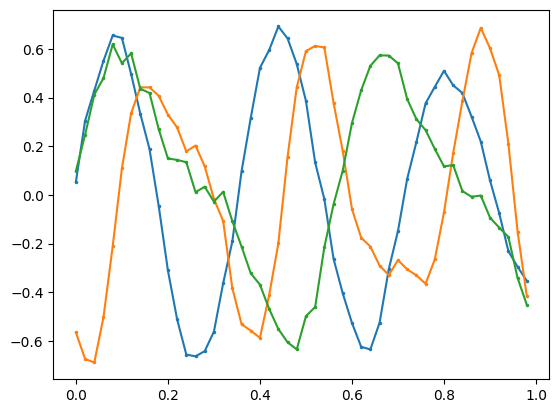

In [31]:

plt.plot(time[:n_steps], X_train[0, :, 0], marker='.', markersize=3)
plt.plot(time[:n_steps], X_train[1, :, 0], marker='.', markersize=3)
plt.plot(time[:n_steps], X_train[2, :, 0], marker='.', markersize=3)

In [6]:
print("Train ", X_train.shape, y_train.shape)
print("Valid ", X_valid.shape, y_valid.shape)
print("Test ", X_test.shape, y_test.shape)

Train  (7000, 50, 1) (7000, 1)
Valid  (2000, 50, 1) (2000, 1)
Test  (1000, 50, 1) (1000, 1)


In [7]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

2023-02-12 21:26:53.381168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.020440727

In [8]:
y_pred.shape, y_valid.shape, X_valid.shape

((2000, 1), (2000, 1), (2000, 50, 1))

# Fully Connected Network as shown below

In [9]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0811 - accuracy: 0.0000e+00 - val_loss: 0.0323 - val_accuracy: 0.0000e+00
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0204 - accuracy: 0.0000e+00 - val_loss: 0.0148 - val_accuracy: 0.0000e+00
Epoch 3/20
219/219 [==============================] - 0s 994us/step - loss: 0.0111 - accuracy: 0.0000e+00 - val_loss: 0.0096 - val_accuracy: 0.0000e+00
Epoch 4/20
219/219 [==============================] - 0s 993us/step - loss: 0.0080 - accuracy: 0.0000e+00 - val_loss: 0.0077 - val_accuracy: 0.0000e+00
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0068 - accuracy: 0.0000e+00 - val_loss: 0.0069 - val_accuracy: 0.0000e+00
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 0.0000e+00 - val_loss: 0.0064 - val_accuracy: 0.0000e+00
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0058 - accuracy: 0.0

In [10]:
y1 = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(y_test, y1))

32/32 [==============================] - 0s 653us/step


0.0038214838

In [11]:
y1.shape, y_test.shape, X_valid[:, -1].shape, y_valid.shape

((1000, 1), (1000, 1), (2000, 1), (2000, 1))

In [12]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 0.1396 - accuracy: 0.0000e+00 - val_loss: 0.1460 - val_accuracy: 0.0000e+00
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.1393 - accuracy: 0.0000e+00 - val_loss: 0.1468 - val_accuracy: 0.0000e+00
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.1397 - accuracy: 0.0000e+00 - val_loss: 0.1459 - val_accuracy: 0.0000e+00
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1387 - accuracy: 0.0000e+00 - val_loss: 0.1424 - val_accuracy: 0.0000e+00
Epoch 5/20
219/219 [==============================] - 1s 5ms/step - loss: 0.1392 - accuracy: 0.0000e+00 - val_loss: 0.1430 - val_accuracy: 0.0000e+00
Epoch 6/20
219/219 [==============================] - 1s 5ms/step - loss: 0.1395 - accuracy: 0.0000e+00 - val_loss: 0.1420 - val_accuracy: 0.0000e+00
Epoch 7/20
219/219 [==============================] - 1s 5ms/step - loss: 0.1391 - accuracy: 0.0000e

In [13]:
y2 = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(y_test, y2))

32/32 [==============================] - 0s 2ms/step


0.13692223

In [14]:
y2.shape, y_test.shape

((1000, 1), (1000, 1))

In [15]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[50, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(20)
])
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=20)


Epoch 1/20
219/219 [==============================] - 4s 11ms/step - loss: 0.0519 - accuracy: 0.0000e+00
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0065 - accuracy: 0.0000e+00
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0046 - accuracy: 0.0000e+00
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0039 - accuracy: 0.0000e+00
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0035 - accuracy: 0.0000e+00
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0034 - accuracy: 0.0000e+00
Epoch 7/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0032 - accuracy: 0.0000e+00
Epoch 8/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0031 - accuracy: 0.0000e+00
Epoch 9/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0030 - accuracy: 0.0000e+00
Epoch 10/20
219/219 [==============================] - 

In [16]:
y3 = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(y_test, y3))

32/32 [==============================] - 0s 3ms/step


0.002991523

In [17]:
y3.shape, y_test.shape

((1000, 20), (1000, 1))

In [18]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[50, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))


Epoch 1/20
219/219 [==============================] - 9s 26ms/step - loss: 0.1436 - accuracy: 0.0000e+00 - val_loss: 0.1455 - val_accuracy: 0.0000e+00
Epoch 2/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1428 - accuracy: 0.0000e+00 - val_loss: 0.1455 - val_accuracy: 0.0000e+00
Epoch 3/20
219/219 [==============================] - 5s 21ms/step - loss: 0.1414 - accuracy: 0.0000e+00 - val_loss: 0.1455 - val_accuracy: 0.0000e+00
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.1412 - accuracy: 0.0000e+00 - val_loss: 0.1431 - val_accuracy: 0.0000e+00
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1405 - accuracy: 0.0000e+00 - val_loss: 0.1431 - val_accuracy: 0.0000e+00
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1385 - accuracy: 0.0000e+00 - val_loss: 0.1410 - val_accuracy: 0.0000e+00
Epoch 7/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1381 - accuracy: 

In [19]:
y4 = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(y4[:, :, 0], y_test))

32/32 [==============================] - 1s 5ms/step


0.07756491

In [20]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[50, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))


Epoch 1/20
219/219 [==============================] - 7s 17ms/step - loss: 0.1434 - val_loss: 0.1455
Epoch 2/20
219/219 [==============================] - 3s 14ms/step - loss: 0.1406 - val_loss: 0.1430
Epoch 3/20
219/219 [==============================] - 3s 14ms/step - loss: 0.1395 - val_loss: 0.1436
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 0.1397 - val_loss: 0.1431
Epoch 5/20
219/219 [==============================] - 3s 13ms/step - loss: 0.1393 - val_loss: 0.1426
Epoch 6/20
219/219 [==============================] - 3s 14ms/step - loss: 0.1391 - val_loss: 0.1431
Epoch 7/20
219/219 [==============================] - 3s 14ms/step - loss: 0.1389 - val_loss: 0.1422
Epoch 8/20
219/219 [==============================] - 3s 13ms/step - loss: 0.1384 - val_loss: 0.1431
Epoch 9/20
219/219 [==============================] - 3s 13ms/step - loss: 0.1371 - val_loss: 0.1398
Epoch 10/20
219/219 [==============================] - 3s 13ms/step - loss: 0.1354 - val_lo

In [21]:
y5 = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(y5[:, :, 0], y_test))

32/32 [==============================] - 1s 3ms/step


0.07448668